เราจะเจาะลึกเข้าไปใน Model ว่า การทำงานตัวอย่างเช่น Classification โมเดล พิจารณารูปภาพที่จุดไหน โฟกัสบริเวณได้ ในการจำแนกว่ารูปนี้คือสัตว์สายพันธุ์อะไร

# 0. Magic

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. Data

In [0]:
path = untar_data(URLs.PETS)
path_images = path/'images'
filenames = get_image_files(path_images)

# 3. Data Preparation

In [4]:
batchsize = 64
np.random.seed(42)
regex_pattern = r'/([^/]+)_\d+.jpg$'
tfms = get_transforms()
size = 352

databunch = ImageList.from_folder(path_images) \
              .split_by_rand_pct() \
              .label_from_re(regex_pattern) \
              .transform(tfms, size=size) \
              .databunch(bs=batchsize) \
              .normalize(imagenet_stats)
len(databunch.train_ds), len(databunch.valid_ds)

(5912, 1478)

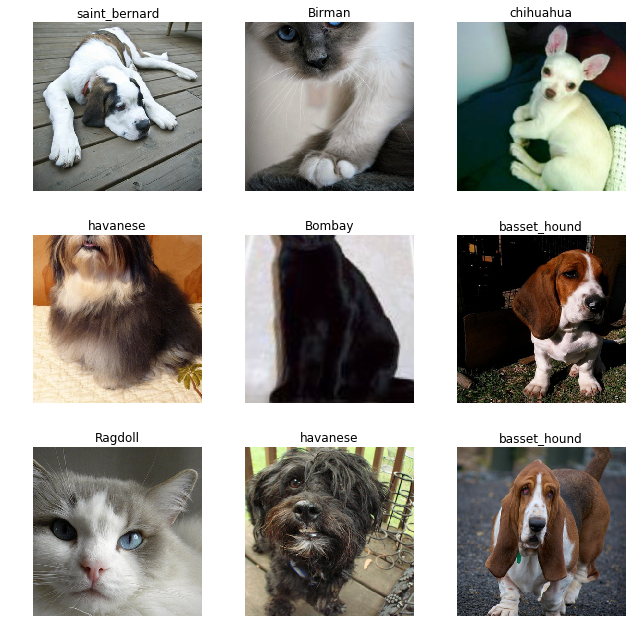

In [5]:
databunch.show_batch(rows=3, figsize=(9, 9))

# 4. Model

epoch,train_loss,valid_loss,accuracy,time
0,1.312004,0.577648,0.832882,03:14


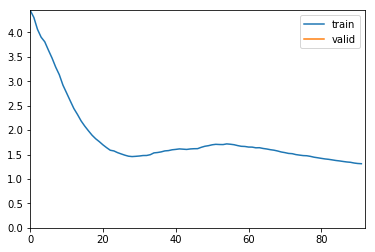

In [6]:
learner = cnn_learner(databunch, models.resnet34, wd=1e-1, \
                      metrics=[accuracy], callback_fns=[ShowGraph])
learner.fit_one_cycle(1, max_lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.651928,0.423806,0.868742,03:23
1,0.530433,0.430080,0.861299,03:27
2,0.353355,0.253500,0.918133,03:26
3,0.253924,0.234635,0.928958,03:27


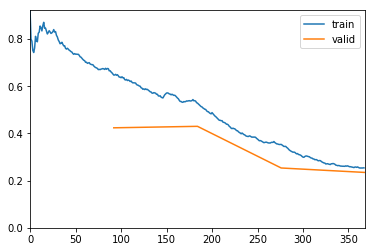

In [7]:
learner.unfreeze()
learner.fit_one_cycle(4, max_lr=slice(3e-6, 3e-3))

ดู Shape ของ Output ของแต่ละ Layer

In [8]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

ดูข้อมูล ของแต่ละ Layer

In [9]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

เราจะสนใจ Conv Layer สุดท้ายของโมเดล

In [10]:
learner.model[0][7][2].conv2

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# 5. Activation Heatmap

เราจะมาสร้าง Heatmap จาก Activation ที่ออกมาจาก Conv2d Layer สุดท้ายของโมเดล ถ้าดูจาก model.summary จะได้มิติ เป็น [512, 11, 11] 

ลองดูรูปก่อน

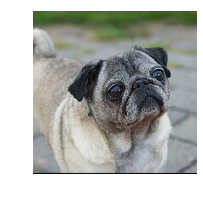

In [157]:
model = learner.model.eval()
index = 72
x, y = databunch.valid_ds[index]

xb, _ = databunch.one_item(x)
xb_image = Image(databunch.denorm(xb)[0])
xb_image.show()

In [158]:
y

Category pug

In [0]:
xb = xb.cuda()

เราจะสร้าง Hook ใส่ไว้ใน PyTorch Model เพื่อเก็บค่า Activation และ Gradient ตรง Output

*เราสามารถระบุได้ว่า ให้ Backpropagation จาก Class ไหน หมายถึง ให้มองหา Class นี้ว่าอยู่ตรงไหนของรูป*

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
  with hook_output(model[0]) as hook_a:
    with hook_output(model[0], grad=True) as hook_g:
      preds = model(xb)
      preds[0, int(cat)].backward()
  return hook_a, hook_g

รันโมเดล Feedforward เพื่อหา Activation และ Backpropagation เพื่อหา Gradient

In [0]:
hook_a, hook_g = hooked_backward()

ได้ค่า Activation ออกมาจากโมเดล

In [163]:
# acts = activations
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

นำ Activation มาหาค่าเฉลี่ย จากทั้ง 512 Channel ว่าตำแหน่งไหน Active ที่สุด

In [164]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

ประกาศฟังก์ชัน แสดง Heatmap โดยขยาย Activation ขนาด 11 x 11 เป็น ขนาดตามรูปจริง ด้วย Bilinear Interpolation

In [0]:
def show_heatmap(xb_im, hm):
  _, ax = plt.subplots(figsize=(9, 9))
  xb_im.show(ax)
  ax.imshow(hm, alpha=0.6, extent=(0, size, size, 0), 
            interpolation='bilinear', cmap='magma')

เราจะเห็นว่าโมเดล Active ที่สุดที่บริเวณไหน คือ Activation เฉลี่ยมากที่สุดในตำแหน่งไหน ใน 11x11

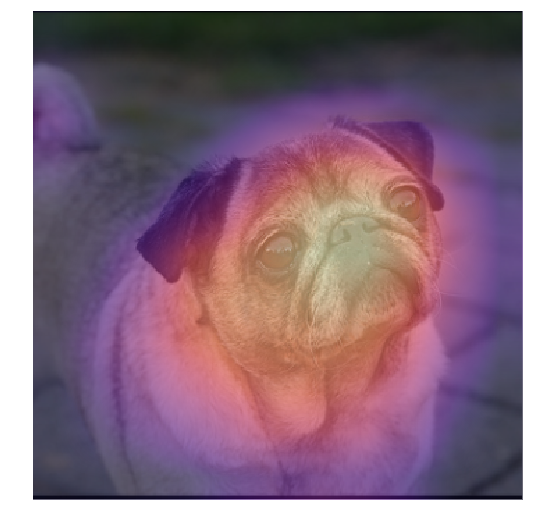

In [166]:
show_heatmap(xb_image, avg_acts)

# 6. Grad-CAM

คราวนี้ แทนที่เราจะคิดว่าทุก Channel มีความสำคัญเท่ากันหมด แต่จริง ๆ แล้ว แต่ละ Chanel จะ Active ไม่เท่ากัน ดังนั้นเราจะนำ Gradient ของแต่ละ Channel มาช่วย Weight ว่า Channel ไหน Active มาก Activation ก็ควรได้ Weight มาก

In [167]:
# grad = gradient, grad_chan = gradient channels
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

เอาค่าเฉลี่ยของ Gradient แต่ละ channel ที่ได้ คูณ Activation กลับเข้าไป แล้วจึงนำมาหาค่าเฉลี่ย

In [0]:
mult = (acts*grad_chan[..., None, None]).mean(0)

ผลที่ได้คือ Heatmap ของ Activation ที่ Weight ตาม Gradient เฉลี่ยของแต่ละ Channel

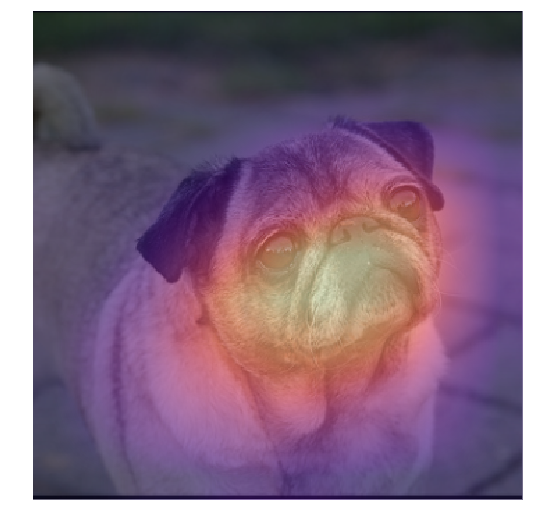

In [169]:
show_heatmap(xb_image, mult)

# 7. สรุป

1. แทนที่เราจะมองว่า Neural Network เป็นกล่องดำ เป็นปริศนาว่ามันทำงานอย่างไร เราสามารถเจาะลึก เข้าไปดูการทำงานข้างในของมันได้ โดยไม่ยากเย็น
1. ในโมเดล Neural Network ขณะที่ทำงาน จะมี Activation ขณะ Feedforward และ Gradient ขณะ Backpropagation เราสามารถนำทั้งสองอย่างมาตีความ ให้เข้าใจถึงการทำงานภายในได้ดีขึ้น
1. ไม่ใช่แค่ตัว Activation และ Gradient เท่านั้น แต่ความสัมพันธ์ของ Activation, Gradient ในแต่ละ Layer ก็สามารถนำมาตีความได้อีก เช่น Perceptual Loss, Style Transfer, etc. จะอธิบายต่อไป

# Credit

* Lesson 6: Regularization; Convolutions; Data ethics https://course.fast.ai/videos/?lesson=6
* Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization https://arxiv.org/abs/1610.02391
* Perceptual Losses for Real-Time Style Transfer and Super-Resolution https://arxiv.org/abs/1603.08155